In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, get_treatment_info
from datetime import datetime   

import seaborn as sns
sns.set_theme(style='white')

#from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

from scipy.stats import zscore, spearmanr

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


color_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

regions = list(color_dict.keys())
region_colors = list(color_dict.values())

all_obs = pd.read_csv('./data/pathology_filtered_obs_with_regions.csv',index_col=0)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qixun1u7 because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Data downloads

In [ ]:
""" 
# Concatenate slide observations and save them into a single dataframe
# Categorize the obs columns and save them into the dataframe
all_obs = pd.DataFrame()
for sample in tqdm(samples, desc="Processing sample", unit="sample"):
    all_obs = pd.concat([all_obs,
    sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad').obs.copy()],axis=0)
    

all_obs['predicted_region'] = all_obs['predicted_region'].astype('category').cat.set_categories(regions)
all_obs['sample_id'] = all_obs['sample_id'].astype('category').cat.set_categories(samples)

# Get the masked id
treat_info = get_sample_id_mask()
masked_ids = list(treat_info.values())
all_obs['masked_id'] = all_obs['sample_id'].map(treat_info).cat.set_categories(masked_ids)

# Add sample class category column
classes = ['BPH','TRNA','NEADT','CRPC']
all_obs['sample_class'] = pd.Categorical(s.split(' ')[0] for s in all_obs['masked_id']).set_categories(classes)

sample_class_dict = all_obs[['sample_id','sample_class']].groupby('sample_id').first().to_dict()['sample_class']

all_obs['sample_class'].value_counts()

all_obs.to_csv('./data/pathology_filtered_obs_with_regions.csv')

 """

## Expression z-scores (Figure 2b, supplementary)

### Chemokine signaling dotplot (3c)
#### Found in: ./scripts/plot_spatial_chemokine_expression_dotplot.py



### AR-signaling associated genes dotplot (2b)
#### Found in: scripts/plot_spatial_progenitor_expression_dotplot.py



## Test the diffrential expression of key genes between treated and untreated samples

In [94]:
""" 
genes = ['AR','ABCC4','FKBP5','KLK3','MAF','NKX3-1','PMEPA1', # AR regulated genes
'KRT5','KRT15','TP63', # Canonical basal markers
'MMP7','PIGR','LTF','SCGB1A1','SCGB3A1', # Club-like markers
'S100A11','WFDC2','CLU','KRT19','KLF5','ATP1B1','KRT4', # Select representative progenitor markers for main plot
'EGFR','MET' # Putative stemness-type receptors #,'IGF1R','ERBB4','ERBB2'
] 
 """
genes = [
                    'CEBPB','NFKB1','IL1RN','CD68','PLAUR',
                    'CXCL1','CXCL2','CXCL3','CXCL5','CXCL6','CXCL8','CXCR1','CXCR2',
                    'CXCL16','CXCR6',
                    'CCL20','CCR6',
                    'CCL2','CCL3','CCL4','CCL5','CCR2','CCR5',
                    'CXCL9','CXCL10','CXCL11','CXCR3',
                    'CCL17','CCL22','CCR4',
                    'CCL19','CCL21','CCR7',
                    'CXCL12','CXCR4'
                    ]


unt = get_sample_ids_reorder(['untreated'])
trt = get_sample_ids_reorder(['bicalutamide','goserelin','degarelix','degarelix_apalutamide'])

In [121]:
def fetch_region_normalized_expression_and_percentage(gene_markers, sample_list, region, use_unnormalized = True):
    '''
    Returns the per-sample mean expression of genes of interest across all samples that are defined in sample_list
    inside a region defined by region parameter.
    '''

    final_expression_df = pd.DataFrame()
    final_percentage_df = pd.DataFrame()
    

    print('Region: ' + region)
    region_expression_df = pd.DataFrame()

    for sample in tqdm(sample_list, desc="Processing samples", unit="sample"):
        
        slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
        slide_subs = slide[slide.obs['predicted_region']==region].copy()

        # Control for the number of data points belonging to a class
        if slide_subs.shape[0] >= 10:
            
            present_genes = [g for g in gene_markers if g in slide_subs.var_names]
            missing_genes = [g for g in gene_markers if g not in slide_subs.var_names]

            genes_all_arr_order_match = present_genes + missing_genes

            if use_unnormalized:
                expr_without_missing_genes = slide_subs[:,present_genes].layers['counts'].copy().todense()
            else:
                expr_without_missing_genes = slide_subs[:,present_genes].X.copy().todense()


            expr_all_spots = np.concatenate((expr_without_missing_genes,np.full((expr_without_missing_genes.shape[0],len(missing_genes)), np.nan)),axis=1)

            expr_as_df = pd.DataFrame(data=expr_all_spots.T,index=genes_all_arr_order_match,columns=slide_subs.obs_names)
            expr_as_df = expr_as_df.loc[gene_markers]
            
            # Concatenate the counts from a single sample into a dataframe with all the spots
            region_expression_df = pd.concat([region_expression_df,expr_as_df],axis=1)

        del slide, slide_subs

    return(region_expression_df)

In [122]:
reg = 'Immune'
untreated_expression = fetch_region_normalized_expression_and_percentage(genes,unt,reg)#,use_unnormalized=False
treated_expression = fetch_region_normalized_expression_and_percentage(genes,trt,reg)#,use_unnormalized=False

treated_expression = treated_expression.fillna(0)
untreated_expression = untreated_expression.fillna(0)

Region: Immune


Processing samples: 100%|██████████| 17/17 [00:17<00:00,  1.00s/sample]


Region: Immune


Processing samples: 100%|██████████| 22/22 [00:26<00:00,  1.21s/sample]


In [123]:
from scipy.stats import mannwhitneyu, ranksums

print('Positive diff means increased expression post-treatment')
for g in genes:

    stat, pval = ranksums(untreated_expression.loc[g],treated_expression.loc[g])
    mean_diff = treated_expression.loc[g].mean() - untreated_expression.loc[g].mean() 

    print(g)
    if pval < 0.001:
        print('Diff: {:.1f}, P-value: {:.1e} !!!'.format(mean_diff,pval))
    elif pval < 0.01:
        print('Diff: {:.1f}, P-value: {:.1e} !!'.format(mean_diff,pval))
    elif pval < 0.05:
        print('Diff: {:.1f}, P-value: {:.1e} !'.format(mean_diff,pval))
    else:
        print('Diff: {:.1f}, P-value: {:.1e}'.format(mean_diff,pval))

    print('')

Positive diff means increased expression post-treatment
CEBPB
Diff: -0.1, P-value: 2.9e-06 !!!

NFKB1
Diff: -0.1, P-value: 1.6e-06 !!!

IL1RN
Diff: 0.0, P-value: 3.0e-01

CD68
Diff: -0.0, P-value: 6.8e-01

PLAUR
Diff: -0.0, P-value: 6.5e-02

CXCL1
Diff: -0.0, P-value: 2.1e-01

CXCL2
Diff: -0.1, P-value: 2.0e-04 !!!

CXCL3
Diff: -0.0, P-value: 4.4e-01

CXCL5
Diff: -0.0, P-value: 9.8e-01

CXCL6
Diff: -0.0, P-value: 5.6e-01

CXCL8
Diff: -0.1, P-value: 2.2e-03 !!

CXCR1
Diff: -0.0, P-value: 9.5e-01

CXCR2
Diff: -0.0, P-value: 9.2e-01

CXCL16
Diff: -0.1, P-value: 9.0e-06 !!!

CXCR6
Diff: -0.0, P-value: 1.0e-01

CCL20
Diff: 0.0, P-value: 6.5e-01

CCR6
Diff: -0.1, P-value: 2.0e-02 !

CCL2
Diff: -0.3, P-value: 5.1e-22 !!!

CCL3
Diff: -0.0, P-value: 1.4e-01

CCL4
Diff: -0.1, P-value: 7.2e-07 !!!

CCL5
Diff: -0.2, P-value: 2.0e-09 !!!

CCR2
Diff: -0.1, P-value: 6.8e-03 !!

CCR5
Diff: -0.1, P-value: 2.7e-02 !

CXCL9
Diff: -0.1, P-value: 7.5e-04 !!!

CXCL10
Diff: 0.0, P-value: 8.6e-01

CXCL11
Diff

In [69]:
for sample in unt:
    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
    print(sample)
    print(slide.var_names.isin(['CXCR1']).any())

PC-03-6712
False
PC_00_16338_II
False
PC_01_06342_VAS
False
PC_01_14451_OIK
False
PC_02_05601_OIK
False
PC_02_10136_VAS
False
PC_03_01669_TUTKV
False
PC_15420OIK
False
PC_4980
True
PC_7875OIK
False
PC_05_08449_OIK_POST_0
False
PC_05_13057_OIK_ANT_0
False
PC_05_30627_VAS_ANT_0
False
PC_06_02588_OIK_ANT_0
True
PC_06_04581_OIK_POST_0
False
PC_06_17800_VAS_POST_0
False
PC_04_12646_VAS
False


In [62]:
treated_expression.loc['CXCR1'].describe()

count   3.7e+03
mean    0.0e+00
std     0.0e+00
min     0.0e+00
25%     0.0e+00
50%     0.0e+00
75%     0.0e+00
max     0.0e+00
Name: CXCR1, dtype: float64

## Sample proportion swarmplots (Figure 3a)

In [2]:
all_obs = pd.read_csv('./data/pathology_filtered_obs_with_regions.csv',index_col=0)

In [3]:
from scripts.utils import get_treatment_info

treat_info = get_treatment_info()
concat_obs = all_obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)

def get_spot_proportions(region,sample_list=samples,obs_df=all_obs,treatment_info=treat_info, re_annotate_treated=True):
    df = pd.DataFrame(index=sample_list,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        sample_df = obs_df[obs_df['sample_id'] == sample].copy()
        df.loc[sample,'total spots'] = len(sample_df)
        df.loc[sample,region + ' spots'] = len(sample_df[sample_df['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)

    if re_annotate_treated:
        # Re-annotate
        df['treatment'] = df['treatment'].replace({'bicalutamide':'treated','goserelin':'treated','degarelix':'treated','degarelix_apalutamide':'treated'})

    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


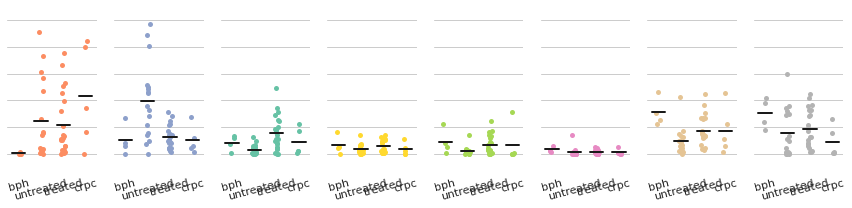

In [4]:
sns.set_theme(style='whitegrid')

order = ['bph', 'untreated', 'treated','crpc']

fig, axs = plt.subplots(1,8,figsize=(12,3))
for i, region in enumerate(regions):
    #sns.set_palette(sns.color_palette([color_dict[region]]))    
    #fig, ax = plt.subplots(figsize=(2,3))
    ax = axs[i]
    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=5, ax=ax, color=color_dict[region]) # color=".7",)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            width=0.6,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    #ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels([''])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
    ax.set_yticklabels([''])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig('./plots/region_proportion_swarmplots/all_region_proportions_swarmplot.pdf')
plt.show()

In [53]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots

from scipy.stats import kruskal,ranksums

# Set to print the dataframe p-values as a specific format
pd.set_option('display.float_format', lambda x: '%.1e' % x)

for region in regions:
    df = get_spot_proportions(region)
    df['treatment'] = df['treatment'].cat.reorder_categories(['bph','untreated','treated','crpc'])

    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df['treatment']

    # perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[values[categories == cat] for cat in set(categories)])

    print(region)
    # print the results
    print("Kruskal-Wallis test")
    print("p-value: {:.3f}".format(p_value))

    if p_value < 0.05:
        treatments = df['treatment'].cat.categories
        res_df = pd.DataFrame(np.eye(len(treatments),len(treatments)),index=treatments,columns=treatments)

        for i in range(len(treatments)):
            for j in range(i+1, len(treatments)):
                # Get data for the two treatments being compared
                data1 = df.loc[df['treatment'] == treatments[i], 'proportion']
                data2 = df.loc[df['treatment'] == treatments[j], 'proportion']
                
                # Perform Mann-Whitney U test
                stat, pval = ranksums(data1, data2)
                
                # Print results
                res_df.loc[treatments[i],treatments[j]] = pval
                res_df.loc[treatments[j],treatments[i]] = pval
        print('Wilcoxon rank-sum test:')
        print(res_df)
    print('')

Tumor
Kruskal-Wallis test
p-value: 0.028
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    7.2e-03  4.5e-03 1.1e-01
untreated 7.2e-03    1.0e+00  9.3e-01 3.7e-01
treated   4.5e-03    9.3e-01  1.0e+00 2.4e-01
crpc      1.1e-01    3.7e-01  2.4e-01 1.0e+00

Luminal epithelium
Kruskal-Wallis test
p-value: 0.002
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    3.2e-02  4.3e-01 1.0e+00
untreated 3.2e-02    1.0e+00  9.2e-04 1.7e-02
treated   4.3e-01    9.2e-04  1.0e+00 3.5e-01
crpc      1.0e+00    1.7e-02  3.5e-01 1.0e+00

Basal epithelium
Kruskal-Wallis test
p-value: 0.004
Wilcoxon rank-sum test:
              bph  untreated  treated    crpc
bph       1.0e+00    7.3e-02  3.2e-01 1.0e+00
untreated 7.3e-02    1.0e+00  4.4e-04 1.7e-01
treated   3.2e-01    4.4e-04  1.0e+00 2.6e-01
crpc      1.0e+00    1.7e-01  2.6e-01 1.0e+00

Club epithelium
Kruskal-Wallis test
p-value: 0.470

Immune
Kruskal-Wallis test
p-value: 

### Check the variance within different ADT treatment groups

In [ ]:
sns.set_theme(style='whitegrid')

order = ['gos', 'bica', 'deg','deg_apa']

treated_samples = get_sample_ids_reorder(['bicalutamide','goserelin','degarelix','degarelix_apalutamide'])

fig, axs = plt.subplots(1,8,figsize=(12,3))
for i, region in enumerate(regions):
    #sns.set_palette(sns.color_palette([color_dict[region]]))    
    #fig, ax = plt.subplots(figsize=(2,3))
    ax = axs[i]
    df = get_spot_proportions(region,sample_list=treated_samples,re_annotate_treated=False)
    df['treatment'] = df['treatment'].replace({'bicalutamide':'bica','goserelin':'gos','degarelix':'deg','degarelix_apalutamide':'deg_apa'})

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=5, ax=ax, color=color_dict[region]) # color=".7",)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            width=0.6,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    #ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels([''])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
    ax.set_yticklabels([''])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('./plots/region_proportion_swarmplots/treatment_region_proportions_swarmplot.pdf')
plt.show()

In [ ]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots

from scipy.stats import kruskal,mannwhitneyu


for region in regions:
    
    df = get_spot_proportions(region,sample_list=treated_samples,re_annotate_treated=False)
    df['treatment'] = df['treatment'].replace({'bicalutamide':'bica','goserelin':'gos','degarelix':'deg','degarelix_apalutamide':'deg_apa'})
    df['treatment'] = df['treatment'].cat.reorder_categories(['gos', 'bica', 'deg','deg_apa'])

    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df['treatment']

    # perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[values[categories == cat] for cat in set(categories)])

    print(region)
    # print the results
    print("Kruskal-Wallis test")
    print("p-value: {:.3f}".format(p_value))

    if p_value < 0.05:
        treatments = df['treatment'].cat.categories
        res_df = pd.DataFrame(np.eye(len(treatments),len(treatments)),index=treatments,columns=treatments)

        for i in range(len(treatments)):
            for j in range(i+1, len(treatments)):
                # Get data for the two treatments being compared
                data1 = df.loc[df['treatment'] == treatments[i], 'proportion']
                data2 = df.loc[df['treatment'] == treatments[j], 'proportion']
                
                # Perform Mann-Whitney U test
                stat, pval = mannwhitneyu(data1, data2)
                
                # Print results
                res_df.loc[treatments[i],treatments[j]] = pval
                res_df.loc[treatments[j],treatments[i]] = pval
        print('Mann-Whitney U-test:')
        print(res_df)
    print('')

## Differential expression analyses (Figure 2b)

### Calculate differential expression in individual regions and individual samples

In [ ]:
# Calculate DEGs between regions individually in samples
# This takes several minutes with method='wilcoxon',
# About a minute with method='t-test'
for sample in tqdm(samples, desc="Processing sample", unit="sample"):

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
    slide.uns['log1p']["base"] = None # https://github.com/scverse/scanpy/issues/2239

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups,random_state=25813063)

    slide.write_h5ad('./data/visium_with_regions_and_degs/'+sample+'_with_regions_and_degs.h5ad')

    


In [ ]:
from scripts.utils import get_sample_id_mask
masked_sample_ids = get_sample_id_mask()

# Take a region one at a time, extract DEG results, save into a list

# Create a dictionary and save appropriate dataframes
region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()
    region_degs_dict[region] = deg_res_all


for sample in tqdm(samples, desc="Processing sample", unit="sample"):

    slide = sc.read_h5ad(('./data/visium_with_regions_and_degs/'+sample+'_with_regions_and_degs.h5ad'))
    
    for region in regions:

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
            deg_res['sample'] = sample #masked_sample_ids[sample]
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)].reset_index(drop=True)

            region_degs_dict[region] = pd.concat([region_degs_dict[region].copy(),deg_res],axis=0)

        except:
            continue

    del slide



In [ ]:
# Save the sample/region-specific DEGs
from scripts.utils import save_to_pickle

date = datetime.now().strftime('%y%m%d')
save_to_pickle(region_degs_dict,'./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [ ]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_3.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value['sample'] = value['sample'].map(sample_id_masks)
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


## Fisher's exact test of individual gene markers

In [ ]:
from scripts.utils import load_from_pickle
date = '240229'
region_degs_dict = load_from_pickle('./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [ ]:
region_sample_counts = {}
df_gene_counts = pd.DataFrame()
for r in regions:
    df_gene_counts = pd.merge(region_degs_dict[r]['names'].value_counts().rename(r),df_gene_counts,left_index=True,right_index=True,how='outer')
    region_sample_counts[r] = len(region_degs_dict[r]['sample'].unique())
df_gene_counts = df_gene_counts.fillna(0).astype(int)


In [ ]:
# Take DEG results and perform enrichment analysis:
# Check in how many samples this gene is overexpressed in a specific region
# Compare this to how many samples the same gene is overexpressed in 
# If there is a significant enrichment for this marker in a region, it can be considired region specific


from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

signif_pval_interactions = {}

for reg in regions:
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

### Format into dataframes and save into an excel file

In [ ]:
# Get the number of regions in each sample and save into a dataframe

df = all_obs[['sample_id','predicted_region']].copy()
df['sample_id'] = df['sample_id'].map(sample_id_masks)
df['sample_id']= df['sample_id'].astype('category').cat.reorder_categories(sample_id_masks.values())
df['count'] = 1
region_counts_df  = df.groupby(['sample_id','predicted_region']).agg({'count':'sum'})

In [ ]:
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/region_prevalences_in_all_samples.xlsx', engine='xlsxwriter')

# Write the dataframe into a  Excel file
region_counts_df.to_excel(writer)

# Save and close the Excel writer
writer.save()

In [ ]:


# Format the region Fisher's exact to a dataframe
for reg in regions:

    n_valid_samples = (region_counts_df.loc[region_counts_df.index.get_level_values(1) == reg]['count'] >=10).sum()
    df = signif_pval_interactions[reg].copy()

    df = df.drop(columns='interface')
    df.columns = ['gene', 'over-expressed in (out of {:d} region-containing samples)'.format(n_valid_samples), 'adjusted p-value (Fishers exact test)']
    df = df.sort_values('adjusted p-value (Fishers exact test)').reset_index(drop=True)
    signif_pval_interactions[reg] = df


# Save the results into an excel-file
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_with_region_marker_fishers.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in signif_pval_interactions.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()

### Create the dotplot and plot it

In [ ]:
# Define gene markers for the dotplot 2b
marker_genes_for_hmap = ['PRAC1','HPN','PCAT14','AMACR','PCA3', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','TP63','SLC14A1', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Intermediate
                         'CXCR4','TRBC1','CD3D','LYZ','CD79A', # Lymphocyte
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','SFRP2','COL1A1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [ ]:
from scripts.utils import load_from_pickle
region_degs_dict = load_from_pickle('./data/region_gene_markers_signif_degs_240229.pkl')

In [ ]:
# Create the dotplot structure

plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

In [ ]:

# Create the dotplot
sns.set(style='white')

width = 18
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_gene_markers_dotplot.pdf',transparent=True)
plt.show()


### Miscellaneous supplementary tables

In [ ]:
obs_subset = all_obs # all_obs[all_obs['sample_class']=='NEADT']
(obs_subset.predicted_region.value_counts()/len(obs_subset)*100).round(1)

## Spatial plots in a grid (Supplementary)

### Tissue H&E

In [ ]:
sns.set_theme(style='white')
sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())

it=0
fig, axs = plt.subplots(10, 5, figsize=(15, 30),dpi=300)

for i in tqdm(range(10),desc='Row completion'):
    for j in range(5):
        
        if it < len(samples):

            sample_name = samples[it]
            
            slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')

            if 'P320' in sample_name:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        #    crop_coord=sample_crop_coord[samples[it]],
                            size=0, alpha_img=1, legend_loc=None,
                            ax=axs[i,j],show=False
                            )

            else:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        crop_coord=sample_crop_coord[sample_name],
                        size=0, alpha_img=1, legend_loc=None,
                        ax=axs[i,j],show=False
                        )
                
            del slide
                
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()


plt.savefig('./plots/HE_all_samples_spatial.png',dpi=120)
plt.clf()
#plt.show()


### Single sample high quality

In [ ]:
sns.set_theme(style='white')
sample_name = 'PC_06_04581_OIK_POST_0'
fig, ax = plt.subplots(figsize=(5, 5))


slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')
sc.pl.spatial(slide,color='predicted_region',
        crop_coord=sample_crop_coord[sample_name],
        size=1.3, alpha_img=1, legend_loc=None,
        ax=ax,show=False
        )

plt.title('')
plt.xlabel('')
plt.ylabel('')

plt.savefig('./plots/all_samples_grid/individually_with_he/'+sample_name.replace(' ', '_')+'.png',dpi=1200,transparent=True)
plt.clf()
#plt.show()

In [ ]:
# Plot region interactions schematic in high-resolution

sample_name = 'PC_06_04581_OIK_POST_0'
roi = 'Club epithelium'
interacting_reg = 'Fibroblast'


sns.set_theme(style='white')
sns.set_palette(sns.color_palette([color_dict[roi],color_dict[interacting_reg],'whitesmoke']))

fig, ax = plt.subplots(figsize=(5, 5))

slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')


obs_data = slide.obs.copy()
obs_data['to_plot'] = 'null'
obs_data.loc[obs_data['predicted_region'] == roi,'to_plot'] = roi
obs_data.loc[obs_data['predicted_region'] == interacting_reg,'to_plot'] = interacting_reg

obs_data['to_plot'] = obs_data['to_plot'].astype('category').cat.set_categories([roi,interacting_reg,'null'])
slide.obs = obs_data.copy()

sc.pl.spatial(slide,color='to_plot',
        crop_coord=sample_crop_coord[sample_name],
        size=1.3, alpha_img=1, legend_loc=None,
        ax=ax,show=False
        )

plt.title('')
plt.xlabel('')
plt.ylabel('')

plt.savefig('./plots/all_samples_grid/individually_with_he/'+sample_name+'_'+roi.replace(' ','_')+'_'+interacting_reg.replace(' ','_')+'.png',dpi=1200,transparent=True)
plt.clf()
#plt.show()


### Regions on all samples single grid

In [ ]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

sns.set_theme(style='white')
sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())

it=0
fig, axs = plt.subplots(10, 5, figsize=(15, 30),dpi=300)

for i in tqdm(range(10),desc='Row completion'):
    for j in range(5):
        
        if it < len(samples):

            sample_name = samples[it]
            
            slide = sc.read_h5ad('./data/visium_with_regions/'+sample_name+'_with_regions.h5ad')

            if 'P320' in sample_name:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        #    crop_coord=sample_crop_coord[samples[it]],
                            size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                            ax=axs[i,j],show=False
                            )

            else:
                sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample_name],
                        crop_coord=sample_crop_coord[sample_name],
                        size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                        ax=axs[i,j],show=False
                        )
                
            del slide
                
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()

# create custom axes for the annotation legend 
cax1 = fig.add_axes([0.70, 0.0, 0.05, 0.15])
cax2 = fig.add_axes([0.85, 0.0, 0.05, 0.15])

cax1.axis('off')
cax1.legend(handles=legend_handles[:4],loc='center',markerscale=1.5,fontsize='x-large')
cax2.axis('off')
cax2.legend(handles=legend_handles[4:],loc='center',markerscale=1.5,fontsize='x-large')


plt.savefig('./plots/regions_on_all_samples_spatial.pdf')
plt.clf()
#plt.show()


### Regions one sample at a time

In [ ]:
for sample in tqdm(samples, desc="Processing sample", unit="sample"):
    
    it=0

    fig, axs = plt.subplots(2, 4, figsize=(12, 6),dpi=300)

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')

    for i in range(2):
        for j in range(4):
        
            region_of_interest = regions[it]

            if region_of_interest in slide.obs['predicted_region'].unique():
                
                slide.obs['region_of_interest'] = np.nan

                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

            
                n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

                sc.pl.spatial(slide,color='region_of_interest',title=region_of_interest+ ' ({:d})'.format(n_spots),
                        crop_coord=sample_crop_coord[sample],
                        size=1.5, alpha_img=0.0, legend_loc=None,na_color='whitesmoke', # Changed from 0.8
                        ax=axs[i,j],show=False
                        )
                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)

            else:
                axs[i,j].set_visible(False)
            
            it+=1
    
    plt.tight_layout()
    plt.savefig('./plots/all_samples_grid/region_based/sample_specific/'+sample+'_all_regions_individually.pdf')
    plt.clf()
    #plt.show()


### Regions on samples no background individual

In [ ]:
sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())


for sample in tqdm(samples, desc="Processing sample", unit="sample"):
    
    fig, ax = plt.subplots(figsize=(3,3),dpi=200)

    slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')

    if 'P320' not in sample:
        sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample],
                    crop_coord=sample_crop_coord[sample],
                    size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                    ax=ax,show=False
                    )

    else:
        sc.pl.spatial(slide,color='predicted_region',title=sample_id_mask_dict[sample],
                    size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                    ax=ax,show=False
                    )
    plt.tight_layout()


    plt.savefig('./plots/all_samples_grid/region_based/individually/'+sample.replace(' ', '_')+'.pdf',transparent=True)
    plt.clf()
    #plt.show()


### Regions one at a time on all samples single grid

In [ ]:

for region_of_interest in regions:
    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                slide = adata_slides[samples[it]].copy()
                slide.obs['region_of_interest'] = np.nan
                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

                try:
                    n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]
                except:
                    n_spots=0

                sc.pl.spatial(slide,color='region_of_interest',title=samples[it]+ ' ({:d})'.format(n_spots),
                            crop_coord=sample_crop_coord[samples[it]],
                            size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


    plt.savefig('./plots/all_samples_grid/'+region_of_interest+'_region_on_all_spatial_sections.pdf')
    plt.clf()
    #plt.show()


## Stacked barplot of region proportions on samples + sample mask order (Supplementary)

In [ ]:
df = all_obs[['sample_id','predicted_region']]

# Calculate the proportion of data points in each predicted_region class
counts = df['predicted_region'].value_counts(normalize=True)

# Pivot the dataframe to create a matrix of values
df_pivot = df.pivot_table(index='sample_id', columns='predicted_region', aggfunc='size', fill_value=0)

# Normalize the values in each row
df_norm = df_pivot.div(df_pivot.sum(axis=1), axis=0)

treat_info = get_treatment_info()
for k in list(treat_info.keys()):
    if (treat_info[k] == 'bicalutamide') | (treat_info[k] ==  'goserelin'):
        treat_info[k] = 'neoadjuvant'


df_norm['treatment'] = df_norm.index.map(treat_info)

# Get the sample ids into a order where they are grouped by sample categories, but also decrease in tumor 
# content within categories
stacked_bar_sample_order = []
for trt in df_norm['treatment'].unique():
    stacked_bar_sample_order += df_norm[df_norm['treatment'] == trt].sort_values(['Tumor'],ascending=False).index.tolist()

In [ ]:
# assuming your dataframe is named df
pivot_table = df.groupby('sample_id')['predicted_region'].value_counts(normalize=True).unstack()

# Set the pre-defined order
pivot_table = pivot_table.loc[stacked_bar_sample_order]

# plot the stacked barplot
fig, ax = plt.subplots(figsize=(12,3),dpi=300)
pivot_table.plot.bar(stacked=True, color=region_colors,legend=False,width=0.8,edgecolor='black',ax=ax)

# add labels and title
plt.xlabel('Sample ID Class')
plt.ylabel('Count')
plt.gca().set_yticks([0.2,0.4,0.6,0.8,1.0])

#plt.tight_layout()
plt.savefig('plots/region_proportions_all_samples.pdf')
plt.clf()


In [ ]:
# Save the masking dict in this order

pseoudo_ids = ['BPH ' + str(i) for i in np.arange(1,5)] + ['TRNA ' + str(i) for i in np.arange(1,18)] + ['NEADT ' + str(i) for i in np.arange(1,12)] + ['CRPC ' + str(i) for i in np.arange(1,6)]
masking_dict = dict(zip(stacked_bar_sample_order,pseoudo_ids))
masking_df = pd.DataFrame(masking_dict,index=np.arange(1)).T.reset_index()
masking_df.columns = ['PAD','Pseudo_ID']
masking_df.to_csv('patient_id_mask.csv',sep=';',index=False)

### Barplot with region prevalence (Figure 2d top)

In [ ]:
# Barplot of the numer of spots belonging to each region
concat_obs = pd.DataFrame()
for sample in samples:
    concat_obs = pd.concat([concat_obs,adata_slides[sample].obs.copy()],axis=0)

plt.figure(figsize=(3,3))
barplot_df = concat_obs.predicted_region.value_counts().loc[regions]
barplot_df.plot.bar(color=region_colors,width=1)
plt.axhline(y=10000,linestyle='--',color='black',linewidth=1)
plt.axhline(y=20000,linestyle='--',color='black',linewidth=1)
plt.xticks(rotation=60)
plt.savefig('./plots/region_prevalence_barplot.pdf')